For faster development speed, type `Ctrl + M, H` to view Google Colab keyboard shortcuts.

In [1]:
!pip install pytorch-lightning --quiet
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev
!pip install sdv --quiet

     |████████████████████████████████| 675kB 8.9MB/s 
     |████████████████████████████████| 276kB 34.6MB/s 
     |████████████████████████████████| 829kB 29.7MB/s 
     |████████████████████████████████| 102kB 9.9MB/s 
     |████████████████████████████████| 71kB 4.6MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 12.4MB 322kB/s 
     |████████████████████████████████| 1.1MB 44.3MB/s 
     |████████████████████████████████| 225kB 47.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: rdt 0.2.10 has requirement pandas<1.1.5,>=1.1, but you'll have pandas 1.1.5 which is incompatible.


### Getting Started


#### Mounting your Google Drive

In [2]:
# np-pd-mpl
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from numpy.lib.ufunclike import _deprecate_out_named_y

# Neural network packages
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.utils.data
import torch.optim
import pytorch_lightning as pl 
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Built-in
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import time
import copy
import random
import pickle
from typing import List, Tuple, Dict, Any
import logging
logging.getLogger('lightning').setLevel(0)

# sklearn
from sklearn import feature_selection
import sklearn.preprocessing
import sklearn.metrics
from sklearn import model_selection
from sklearn import decomposition

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Running the following cell will generate a message asking you to click on a link where you'll obtain an authorization code.

Paste that authorization code into the text box that appears below to access Google Drive from this notebook.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
!cd "/content/gdrive/MyDrive/" && ls # Displays directories in MyDrive/

 ApTSi		    Education	'School-Related Planning'   地位を申し込む
'Colab Notebooks'   Other	 SCIP
 Data		    Recordings	 temp


In [5]:
dir_path = os.path.join("/content/gdrive/MyDrive/Data", "NNsforGenomics")
os.path.exists(dir_path)

True

In [6]:
!cd {dir_path} && ls

ctgan  data  gans.py  neural_networks.py  preprocessing.py  __pycache__


In [7]:
import sys
sys.path.append(dir_path)
data_path = os.path.join(dir_path, "data")


In [8]:
import ctgan 
import preprocessing
import gans

In [9]:
class TabularDataset(torch.utils.data.Dataset): # inherit from torch
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        X, Y = [arr.astype(float) for arr in [X, Y]]
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y.reshape(-1,1))

        self.n_samples = X.shape[0]
        if self.X.shape[0] != self.Y.shape[0]:
            raise ValueError("Shape mismatch. X and Y should have the same " 
                + "number of rows")

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
    def __len__(self):
        return self.n_samples

In [14]:
class LitFFNN(pl.LightningModule):
    # ----------------------------------
    # Initialize constants and NN architecture
    # ----------------------------------
    def __init__(self, X: np.ndarray, Y: np.ndarray, 
                 data_dir: str = data_path, batch_size: int = 50, 
                 train_set: TabularDataset, val_set: TabularDataset, 
                 test_set: TabularDataset):
        """ Feed-Forward Neural Network System
        Args:
            X (np.ndarray): Feature matrix 
            Y (np.ndarray): Target matrix
        """
        super().__init__()
        # TODO: train-val-test splits
        self.X, self.Y = X, Y
        self.n_features = self.X.shape[1]

        # Hard-coded constants
        self.loss_fn = nn.NLLLoss()
        self.BATCH_SIZE = batch_size
        self.lr = 1e-2
        self.N_CLASSES = 3
        
        self.epoch = 0

        # ----------------------------------
        # Architecture
        # ----------------------------------
        self.D_IN = self.X.shape[1]
        # D_h_in = int((2/3) * self.D_IN)
        # D_h_out = int((1/3) * self.D_IN) 
        hidden_dim = int(np.sqrt(self.D_IN * self.N_CLASSES))
        D_h_in = hidden_dim
        D_h_out = hidden_dim

        self.fc_layers = nn.Sequential(
            nn.Linear(self.D_IN, D_h_in),
                nn.LeakyReLU(),
                nn.Dropout(p = 0.1),
            nn.Linear(D_h_in, D_h_out),
                nn.LeakyReLU(),
                nn.Dropout(p = 0.2),
            nn.Linear(D_h_out, self.N_CLASSES)
        )

        self.epoch_train_losses = []
        self.epoch_val_losses = []
        self.best_val_epoch = 0

    def forward(self, x): 
        x = x.float()
        x = self.fc_layers(x)
        logits = F.log_softmax(input = x, dim = 1)
        return logits

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            params = self.parameters(), lr = self.lr)
        return optimizer

    # ----------------------------------
    # Training, validation, and test steps
    # ----------------------------------

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.flatten().long()
        logits = self(x) 
        loss = self.loss_fn(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, 
                 prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx, val=True):
        x, y = batch
        y = y.flatten().long()
        # compute loss
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, 
                 prog_bar=True) # self.log interacts with TensorBoard
        return loss

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx, val = False)

    def training_epoch_end(self, outputs: List[Any]):
        outputs: List[torch.Tensor] = [list(d.values())[0] for d in outputs]
        sum = torch.zeros(1, dtype=float).to(self.device)
        for batch_idx, batch_loss in enumerate(outputs):
            sum += batch_loss.to(self.device)
        avg_batch_loss = (sum / batch_idx)
        self.epoch_train_losses.append({avg_batch_loss[0].item()})

    def validation_epoch_end(self, outputs: List[Any]):
        sum = torch.zeros(1, dtype=float).to(self.device)
        for batch_idx, batch_loss in enumerate(outputs):
            sum += batch_loss.to(self.device)
        avg_batch_loss = (sum / batch_idx) 
        self.epoch_val_losses.append({avg_batch_loss[0].item()})        

    def custom_train(self, n_epochs, plot=True, verbose=False, plot_train=False):
        train_loader = self.train_dl
        val_loader = self.test_dl
        device=self.device
        self.network.to(device)

        train_losses, val_losses = [], []
        best_val_loss = np.infty
        best_val_epoch = 0
        early_stopping_buffer = 10
        epoch = 0
        best_params = None
        for epoch in range(n_epochs):
            train_loss, val_loss = 0.0, 0.0
  
            # Training
            self.network.train()
            for idx, batch in enumerate(train_loader):
                self.optimizer.zero_grad() # clears paramter gradient buffers
                inputs, targets = batch
                # transfer batch data to computation device
                inputs, targets = [
                    tensor.to(device) for tensor in [inputs, targets]]
                targets = targets.long() # converts dtype to Long
                output = self.network(inputs)
                loss = self.loss_fn(output, targets.flatten())
                # back propagation
                loss.backward()
                self.optimizer.step() # update model weights
                train_loss += loss.data.item()
                if (idx % 10 == 0) and verbose:
                    print(f"epoch {epoch+1}/{n_epochs}, batch {idx}.")
            train_loss = train_loss / len(train_loader)
            train_losses.append(train_loss)
           
            # Validation 
            self.network.eval()        
            for batch in val_loader:
                inputs, targets = batch
                inputs, targets = [tensor.to(device) for tensor in batch]
                targets = targets.long() # converts dtype to Long
                output = self.network(inputs)
                loss = self.loss_fn(output, targets.flatten())
                val_loss += loss.data.item()

            val_loss = val_loss / len(val_loader)
            val_losses.append(val_loss)

            if val_loss < best_val_loss:
              best_params = self.network.parameters()
              best_val_loss = val_loss
              best_val_epoch = epoch
            
            # If validation loss fails to decrease for some number of epochs
            # end training
            if np.abs(epoch - best_val_epoch) > early_stopping_buffer:
              break
        
            print(f"Epoch: {epoch}, Training Loss: {train_loss:.3f}, "
                 +f"Validation loss: {val_loss:.3f}")
        
        #self.network.parameters = best_params
        self.best_val_loss = best_val_loss
        self.best_val_epoch = best_val_epoch
        if plot:
            skip_frames = 3
            fig, ax = plt.subplots()
            fig.tight_layout()
            if plot_train:
              ax.plot(np.arange(epoch + 1)[skip_frames:], 
                      train_losses[skip_frames:], '-', label="training set")
            ax.plot(np.arange(epoch + 1)[skip_frames:], 
                    val_losses[skip_frames:], '-', label="test set")
            ax.set(xlabel="Epoch", ylabel="Loss")
            ax.legend()
            plt.show() 
    
    # ----------------------------------
    # Data preparation hooks
    # ----------------------------------
    def prepare_data(self):
        """
        Args:
            X : feature matrix
            Y : target matrix
        X, Y = self.X, self.Y
        global X_train, Y_train
        global X_val, Y_val
        global X_test, Y_test
        splits = np.array([84, 15, 1]) / 100
        train_size, val_size, test_size = splits
        # train-test split
        train_test_splits = model_selection.train_test_split(
            X, Y, test_size = test_size, random_state = 42)
        X_train, X_test, Y_train, Y_test = train_test_splits
        # train-val split
        relative_val_size = val_size / (train_size + val_size)
        train_val_splits = model_selection.train_test_split(
            X_train, Y_train, test_size = relative_val_size,
            random_state = 42)
        X_train, X_val, Y_train, Y_val = train_val_splits
        assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0] 
        """
        pass 
        
    def setup(self, stage=None):
        if stage in ["fit", None]:
            self.train_set = train_set
            self.val_set = val_set
        if stage in ["test", None]:
            self.test_set = test_set

    def get_dataloader(self, stage: str):
        if stage == "train":
            dataset = self.train_set
        if stage == "val":
            dataset = self.val_set
        if stage == "test":
            dataset = self.test_set
        dl = torch.utils.data.DataLoader(
            dataset = dataset, batch_size = self.BATCH_SIZE) 
        return dl 
        
    def train_dataloader(self) -> torch.utils.data.DataLoader:
        return self.get_dataloader("train")
    def val_dataloader(self) -> torch.utils.data.DataLoader:
        return self.get_dataloader("val")
    def test_dataloader(self) -> torch.utils.data.DataLoader:
        return self.get_dataloader("test")
    
    # ----------------------------------
    # Helper functions - Use post-training
    # ----------------------------------
    
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        self.eval()
        x.to(self.device)
        logits = self(x)
        preds = torch.argmax(input = logits, dim=1)
        return preds

    def accuracy(self, pred: torch.Tensor, target: torch.Tensor):
        self.eval()
        if isinstance(pred, torch.Tensor) and isinstance(target, torch.Tensor):
            pred, target = [t.to(self.device) for t in [pred, target]]
        elif isinstance(pred, np.ndarray) and isinstance(target, np.ndarray):
            tensors = [torch.Tensor(t).to(self.device) for t in [pred, target]]
            pred, target = tensors
        else:
            raise ValueError("The types of `pred` and `target` must match. "
                + "These can be np.ndarrays or torch.Tensors.")

        accuracy = pl.metrics.functional.accuracy(pred, target)
        return accuracy

    def f1(self, pred: torch.Tensor, target: torch.Tensor):
        self.eval()
        if isinstance(pred, torch.Tensor) and isinstance(target, torch.Tensor):
            pred, target = [t.to(self.device) for t in [pred, target]]
        elif isinstance(pred, np.ndarray) and isinstance(target, np.ndarray):
            tensors = [torch.Tensor(t).to(self.device) for t in [pred, target]]
            pred, target = tensors
        else:
            raise ValueError("The types of `pred` and `target` must match. "
                + "These can be np.ndarrays or torch.Tensors.")
        f1 = pl.metrics.functional.f1(
            preds = pred, target = target, num_classes = 3, multilabel = True)
        return f1
        
    def multiclass_aucroc(self, pred: torch.Tensor, target: torch.Tensor):
        self.eval()
        if isinstance(pred, torch.Tensor) and isinstance(target, torch.Tensor):
            pred, target = [t.to(self.device) for t in [pred, target]]
        elif isinstance(pred, np.ndarray) and isinstance(target, np.ndarray):
            tensors = [torch.Tensor(t).to(self.device) for t in [pred, target]]
            pred, target = tensors
        else:
            raise ValueError("The types of `pred` and `target` must match. "
                + "These can be np.ndarrays or torch.Tensors.")
        auc_roc = pl.metrics.functional.classification.multiclass_auroc(
            pred = pred, target = target)
        return auc_roc

    def plot_losses(self, plot_train=True):
        skip_frames = 1
        fig, ax = plt.subplots()
        fig.tight_layout()

        n_epochs = len(self.epoch_val_losses)
        self.epoch_train_losses = [s.pop() for s in self.epoch_train_losses]
        self.epoch_val_losses = [s.pop() for s in self.epoch_val_losses]
        if plot_train:
            n_epochs = len(self.epoch_train_losses)
            ax.plot(np.arange(n_epochs)[skip_frames:], 
                    self.epoch_train_losses[skip_frames:], label="train")
        ax.plot(np.arange(n_epochs)[skip_frames:], 
                self.epoch_val_losses[1:][skip_frames:], label="val")
        ax.set(xlabel="Epoch", ylabel="Loss")
        ax.legend()
        plt.show()


In [163]:
try:
    print(f"X.shape: {X.shape},\tY.shape: {Y.shape}")
except:
    pp = preprocessing.Preprocessing()
    Y, names = pp.get_Y(data_path=data_path)
    X = pd.read_csv(os.path.join(data_path, "X.csv")).values
    print(f"X.shape: {X.shape},\tY.shape: {Y.shape}")

X.shape: (4061, 25869),	Y.shape: (4061, 1)


In [164]:
# Specify training and testing sets
try:
    print([A.shape for A in [X_TRAIN, Y_TRAIN, X_TEST, Y_TEST]])
except:
    # train-test split
    test_split = 0.15
    TEST_IDX = np.array(random.sample(range(4061), k = round(test_split * 4061)))
    TRAIN_IDX = np.array(list(set(np.arange(Y.size)).difference(set(TEST_IDX))))

    X_TRAIN, Y_TRAIN = X[TRAIN_IDX], Y[TRAIN_IDX] 
    X_TEST, Y_TEST = X[TEST_IDX], Y[TEST_IDX]

    TRAIN_SET = TabularDataset(X_TRAIN, Y_TRAIN)  
    TEST_SET = TabularDataset(X_TEST, Y_TEST)
    del X

In [165]:
def X_selectk(k: int, tt_split = False) -> np.ndarray:
    """Grabs the X with the "best" k features and returns it. 
    If `tt_split` is true, the train and test splits are applied as well.
    """
    chi2 = feature_selection.chi2
    selectk = feature_selection.SelectKBest(chi2, k = k)
    X = np.vstack([X_TRAIN, X_TEST])
    Y = np.vstack([Y_TRAIN, Y_TEST])
    X_r: np.ndarray = selectk.fit_transform(X, Y.flatten()).astype(float)

    if tt_split:
        return X_r[TRAIN_IDX], X_r[TEST_IDX]
    else:
        return X_r

K_VALS = [int(k) for k in [10, 100, 500, 1e3, 5e3, 10e3, 25e3]]

In [174]:
X_selectk(K_VALS[0], False).shape

(4061, 10)

In [138]:
def PCA_req_components(X: np.ndarray, threshold = 0.99, plot=True, verbose=False):
    n_samples, n_features = X.shape[0], X.shape[1]
    components = min({n_samples, n_features})
    if n_features < components:
        components = n_features
    pca = decomposition.PCA(n_components = components)
    pca.fit(X)
    
    cusum = np.cumsum(pca.explained_variance_ratio_)
    threshold_line = np.ones(components) * threshold
    p_components = np.arange(components) + 1
    if plot:
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(p_components, cusum, label='cumulative variance explained')
        ax.plot(p_components, threshold_line, '--', label='threshold')
        # ax.plot(p_components, pca.explained_variance_ratio_, 'o', 
        #         label='individual variance explained')
        ax.set(title = f"Variance Explained, n_features = {n_features}",
               xlabel = "Principal components", 
               ylabel = "Percentage of Variance Explained")
        ax.legend()
        plt.show()

    reduced_components = list(cusum >= threshold).index(True)
    # Thresholds, required components table
    thresholds = [0.9, 0.95, 0.97, 0.99, 0.999]
    idx = []
    for t in thresholds:
        idx.append(list(cusum >= t).index(True))
    thresholds, idx = [np.array(l) for l in [thresholds, idx]]
    req_components = pd.DataFrame(np.vstack([thresholds, idx]),
                                  index = ["threshold", "principal components"])
    return req_components

def PCA_reduction(X: np.ndarray, n: int) -> np.ndarray:
    """ Transforms a feature matrix with PCA feature reduction.
    Args:
        X (np.ndarray): Feature matrix
        n (int): number of principal axis components
    Returns:
        X_new (np.ndarray): X with PCA feature reduction.
    """
    n_samples, n_features = X.shape[0], X.shape[1]
    pca = decomposition.PCA(n_components = n)
    X_new = pca.fit_transform(X)
    return X_new

In [19]:
# for k in K_VALS:
#     req_components = PCA_req_components(X_selectk(k, False), plot = True, 
#                                         verbose = True)
#     print(f"k: {k}")
#     print(req_components)

### Example outputs: 

The following results come from using the X in `data/X.csv` with methods defined above and running

```python
for k in K_VALS:
    req_components = PCA_req_components(X_selectk(k, False), plot = True, 
                                        verbose = True)
    print(f"k: {k}")
    print(req_components)
```

![alt text][r10]

```
r: 10
                        0     1     2     3      4
threshold             0.9  0.95  0.97  0.99  0.999
principal components  0.0  0.00  0.00  2.00  6.000
```

![alt text][r100]

```
r: 100
threshold             0.9  0.95  0.97   0.99   0.999
principal components  0.0  0.00  3.00  18.00  55.000
```

![alt text][r500]


```
r: 500
threshold             0.9  0.95   0.97   0.99    0.999
principal components  0.0  6.00  22.00  83.00  258.000
```

![alt text][r1k]

```
r: 1000
threshold             0.9   0.95   0.97    0.99    0.999
principal components  1.0  29.00  65.00  182.00  511.000
```

![alt text][r5k]

```
r: 5000
threshold               0.9    0.95    0.97     0.99     0.999
principal components  135.0  329.00  519.00  1024.00  2149.000
```

![alt text][r10k]

```
r: 10000
threshold               0.9    0.95     0.97     0.99     0.999
principal components  359.0  702.00  1008.00  1750.00  3112.000
```

![alt text][r25k]

```
r: 25000
threshold               0.9     0.95     0.97     0.99     0.999
principal components  903.0  1481.00  1934.00  2818.00  3809.000
```

[r10]: https://github.com/Unique-Divine/Neural-Networks-for-Genomic-Risk/raw/master/images/var_explained-r10.png ""

[r100]: https://github.com/Unique-Divine/Neural-Networks-for-Genomic-Risk/raw/master/images/var_explained-r100.png ""

[r500]: https://github.com/Unique-Divine/Neural-Networks-for-Genomic-Risk/raw/master/images/var_explained-r500.png ""

[r1k]: https://github.com/Unique-Divine/Neural-Networks-for-Genomic-Risk/raw/master/images/var_explained-r1k.png ""

[r5k]: https://github.com/Unique-Divine/Neural-Networks-for-Genomic-Risk/raw/master/images/var_explained-r5k.png ""

[r10k]: https://github.com/Unique-Divine/Neural-Networks-for-Genomic-Risk/raw/master/images/var_explained-r10k.png ""

[r25k]: https://github.com/Unique-Divine/Neural-Networks-for-Genomic-Risk/raw/master/images/var_explained-r25k.png ""

---

# Data set balance analysis


counts: [1575 1372 1114]
pcts: [38.784 33.785 27.432]
labels: [0 1 2]


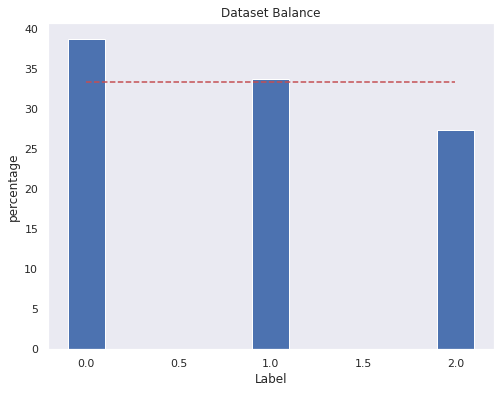

In [88]:
np.set_printoptions(precision = 3)
def balance_check(Y: np.ndarray = Y, verbose=False, plot=False):
    y = pd.Series(Y.flatten(), dtype=int)
    counts = np.array([c for c in [y.value_counts()]]).flatten()
    pcts = counts / counts.sum() * 100
    labels = y.unique()
    if verbose:
        print("counts: {}\npcts: {}\nlabels: {}".format(
        counts, pcts, labels))
    if plot:
        fig, ax = plt.subplots(figsize = (8, 6))
        ax.bar(labels, pcts, width=0.2);
        sweetspot = 1 / labels.size * 100
        sweetspot_line = np.ones(50) * sweetspot
        ax.plot(np.linspace(labels[0], labels[-1]), sweetspot_line, 'r--')
        ax.set(xlabel = "Label", ylabel = "percentage", title="Dataset Balance")
        ax.grid()
        plt.show()
    class DatasetBalance(dict):
        def __init__(self, counts, pcts, labels):
            dictionary = {'counts': counts, 'pcts': pcts, 'labels': labels}
            self.counts = counts
            self.pcts = pcts
            self.labels = labels
            self.update(dictionary)
    balance = DatasetBalance(counts, pcts, labels)
    return balance

balance_check(Y, verbose = True, plot=True);

In [89]:
toy_X = PCA_reduction(X_r(10), n = 6)

In [115]:
def play():
    toy_X.shape, Y.shape
    balance = balance_check()
    
    # get sets of the indices where Y is a certain label
    indices: List[np.ndarray] = []
    for i in balance.labels:
        idx: np.ndarray = np.array((Y == i).flatten().nonzero()[0])
        indices.append(idx)
    
    # randomly select elements of idx in `indices` wihout repetition
    equal_count = balance.counts.min()
    # game = random.sample(population = , k = equal_count)

    return game
play()

1114

In [114]:
random.sample?

---

# Evaluating GAN reasonable GAN parameters



In [ ]:
REAL_DATA = X_new

In [ ]:
start_time = time.time()
g = gans.TabularGANs(
        X = REAL_DATA, Y = Y, 
        gen_dim = (100, 100),
        dis_dim = (10, 10),
        embedding_dim = 1000,
        epochs = 2, 
        l2scale = 1e-4,
        batch_size = 500)
g.train_GANs()
current_time = time.time() - start_time
print(f"training took {current_time:.1f}s")

training took 4.1s


In [ ]:
def eval_test(real_x, real_y, generator_model: gans.TabularGANs) -> float:
    """
    """
    # prepare real data
    real_y = real_y.reshape(-1, 1)
    real_data = np.hstack([real_x, real_y]).astype(float)
    # prepare synth data
    sx, sy = g.create_synth_samples(REAL_DATA.shape[0])
    sy = sy.reshape(-1, 1)
    s = np.hstack([sx, sy]).astype(float)
    # evaluate
    eval: dict = g.evaluate_synth_data(
        synth_data = pd.DataFrame(s), 
        real_data = pd.DataFrame(real_data), 
        aggregate = False)
    eval: float = list(eval.values())[0]
    return eval
eval_test(REAL_DATA, Y, g)

0.623211599768234

In [ ]:
GAN_TESTS = {}

In [ ]:
def gan_parameter_test(real_x, real_y, generator_model: gans.TabularGANs, tests=5):
    original_model = generator_model
    parameters = generator_model.params
    evaluations = np.empty(tests)
    for test in range(tests):
        start_time = time.time()
        test_model = original_model
        test_model.train_GANs()
        current_time = time.time() - start_time
        eta = current_time * (tests - test) 
        print(f"Training step speed {current_time:.1f} s"
            + f"\tETA: {eta:.1f} s")

        evaluation = eval_test(real_x, real_y, generator_model)
        evaluations[test] = evaluation
    score = evaluations.mean()
    GAN_TESTS[score] = parameters

In [ ]:
g = gans.TabularGANs(
    X = REAL_DATA, Y = Y, 
    gen_dim = (20, 20),
    dis_dim = (50, 50),
    embedding_dim = 100,
    epochs = 75, 
    l2scale = 1e-4,
    batch_size = 500)

In [ ]:
gan_parameter_test(REAL_DATA, Y, g)

Training step speed 16.4 s	ETA: 81.9 s
Training step speed 14.2 s	ETA: 56.9 s
Training step speed 14.1 s	ETA: 42.2 s
Training step speed 14.4 s	ETA: 28.9 s
Training step speed 14.2 s	ETA: 14.2 s


In [ ]:
def save_gan_tests(overwrite = False):
    if os.path.exists(os.path.join(data_path, "gan_params.p")) == False:
        with open(os.path.join(data_path, "gan_params.p"), 'wb') as fp:
            pickle.dump(GAN_TESTS, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print("Parameters saved.")
    if overwrite:
        with open(os.path.join(data_path, "gan_params.p"), 'wb') as fp:
            pickle.dump(GAN_TESTS, fp, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        print("The parameters were already saved previously." 
            + "To overwrite the save, set `overwrite = True`.")
    

In [ ]:
def load_gan_tests() -> dict:
    with open(os.path.join(data_path, "gan_params.p"), 'rb') as fp:
        gan_params: dict = pickle.load(fp)
    return gan_params
load_gan_tests()

{0.5674040020528077: {'batch_size': 500,
  'dis_dim': (50, 50),
  'embedding_dim': 100,
  'epochs': 75,
  'gen_dim': (20, 20),
  'l2scale': 0.0001},
 0.5685682816354259: {'batch_size': 500,
  'dis_dim': (50, 50),
  'embedding_dim': 100,
  'epochs': 50,
  'gen_dim': (20, 20),
  'l2scale': 0.0001},
 0.5749121749272297: {'batch_size': 500,
  'dis_dim': (50, 50),
  'embedding_dim': 100,
  'epochs': 5,
  'gen_dim': (5, 5),
  'l2scale': 0.0001},
 0.576530821340115: {'batch_size': 500,
  'dis_dim': (50, 50),
  'embedding_dim': 100,
  'epochs': 100,
  'gen_dim': (20, 20),
  'l2scale': 0.0001},
 0.5785666217070802: {'batch_size': 500,
  'dis_dim': (50, 50),
  'embedding_dim': 100,
  'epochs': 25,
  'gen_dim': (20, 20),
  'l2scale': 0.0001},
 0.5865022262111977: {'batch_size': 500,
  'dis_dim': (50, 50),
  'embedding_dim': 100,
  'epochs': 10,
  'gen_dim': (20, 20),
  'l2scale': 0.0001},
 0.5870081627287909: {'batch_size': 500,
  'dis_dim': (50, 50),
  'embedding_dim': 100,
  'epochs': 5,
  'gen

In [ ]:
try:
    print(gan_model.GANs, "\nGANs are already trained.")
except: 
    gan_model = gans.TabularGANs(
        X = REAL_DATA, Y = Y, 
        epochs = 100)
    print("training GANs...")
    gan_model.train_GANs()
    print(f"GANs trained.\n{ml.GANs}")

training GANs...
GANs trained.


In [ ]:
X_fake, Y_fake = ml.getFakeSamples(n = 1000)
print(X_fake.shape)
Y_fake = np.around(Y_fake).astype(int)
scaler = sklearn.preprocessing.MinMaxScaler()
X_fake = scaler.fit_transform(X_fake)
print(np.array([arr.shape for arr in [X_fake, Y_fake]]))

NameError: ignored

---

# Predictive Modeling



In [16]:
network = LitFFNN(X = X_fake, Y = Y_fake, data_dir=data_path)
trainer = pl.Trainer(max_epochs = 4, gpus = 0, fast_dev_run = True, 
    progress_bar_refresh_rate = 50)
trainer.fit(network)
network.plot_losses(plot_train = True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-b7c1faecba81>", line 1, in <module>
    network = LitFFNN(X = X_fake, Y = Y_fake, data_dir=data_path)
NameError: name 'X_fake' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.6

NameError: ignored

In [ ]:
pred = network.predict(torch.Tensor(X_r))
network.accuracy(pred, torch.Tensor(Y))

tensor(0.3755)

In [ ]:
def test_training_method(verbose = False):
    print("Testing training method: ")
    network = LitFFNN(X = X_fake, Y = Y_fake, data_dir=data_path)
    trainer = pl.Trainer(max_epochs = 4, gpus = 0, fast_dev_run=True, 
                         progress_bar_refresh_rate = 0)
    trainer.fit(network)
    if verbose:
        print(network)
    print("Test passed!\n")

def test_output_consistency():
    print("Testing model output consistency:")
    network = LitFFNN(X_r, Y)
    preds = []
    for i in range(2):
        pred = network.predict(torch.Tensor(X_r))
        preds.append(pred)

    overlap = np.array((preds[0] == preds[1]))
    t = overlap.sum() 
    f = overlap.size - t
    t, f = np.array([t, f]) / (t  + f) 
    print(f"Matched: {t:.2f} %,\tMismatched: {f:.2f} %.\n")

test_output_consistency()
test_training_method()

In [ ]:

# Train and evaluate neural network

# Train and evaluate linear SVC

# Train and evaluate XGB Classifier

```python
# ckpt
import logging
import torch.multiprocessing as mp
from torch.multiprocessing import Manager
from tqdm import tqdm
import time
#mp.set_start_method('spawn')# good solution !!!!

logging.getLogger('lightning').setLevel(0)

early_stop_callback = EarlyStopping(
   monitor='val_acc',
   min_delta=0.00,
   patience=5,
   verbose=False,
   mode='max'
)


def train_model(accuracies, rank):
  start_time = time.time()
  print('rank: ', rank)
  A, indices = sample_from_data(100)
  model = LitFFNN(X = A, Y = Y, 
      data_dir = os.path.join(data_path, "temp"))
  trainer = pl.Trainer(gpus = 0, max_epochs=10, 
      progress_bar_refresh_rate=50, weights_summary=None,
      callbacks=[early_stop_callback], num_sanity_val_steps=0)
  trainer.fit(model)
  acc = model.accuracy(
    y_hat = model.predict(torch.Tensor(A.astype(float))),
    y = torch.Tensor(Y.astype(float))).item()
  accuracies.append(acc)

with Manager() as manager:
  accuracies = manager.list()  # <-- can be shared between processes.
  indices = manager.list()  # <-- can be shared between processes.
  processes = []
  num_processes = 10
  for i in tqdm(range(1)):
    for rank in range(num_processes):
      p = mp.Process(target=train_model, args=(accuracies, rank,))
      p.start()
      processes.append(p)
    for p in processes:
      p.join()
  accuracies = list(accuracies)
  ```